In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/6th sem project"


'model (1).h5'					        test_essays.csv     train_v2_drcat_02.csv
'new_approach_using_bert_and_vectorization (1).ipynb'   train_essays.csv
 subtaskA_train_monolingual.jsonl		        train_prompts.csv


In [ ]:
!cp "/content/drive/My Drive/6th sem project/train_essays.csv" "train_essays.csv"
!cp "/content/drive/My Drive/6th sem project/test_essays.csv" "test_essays.csv"
!cp "/content/drive/My Drive/6th sem project/train_prompts.csv" "train_prompts.csv"
!cp "/content/drive/My Drive/6th sem project/train_v2_drcat_02.csv" "train_v2_drcat_02.csv"

In [ ]:
pip install tensorflow-text


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import tensorflow_text as tf_text
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras import Model, Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
train=pd.read_csv("train_essays.csv")
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [ ]:
test=pd.read_csv("test_essays.csv")
test.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [ ]:
train_prompts=pd.read_csv("train_prompts.csv")
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [ ]:
train['prompt_id'].value_counts()

0    708
1    670
Name: prompt_id, dtype: int64

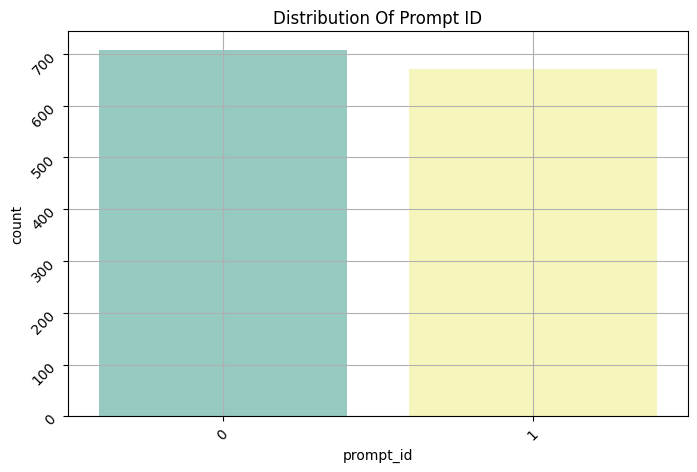

In [ ]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train,x="prompt_id",palette='Set3')
abs_values = train['prompt_id'].value_counts().values
# ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Prompt ID")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


In [ ]:
train['generated'].value_counts()#0: human, 1: ai


0    1375
1       3
Name: generated, dtype: int64

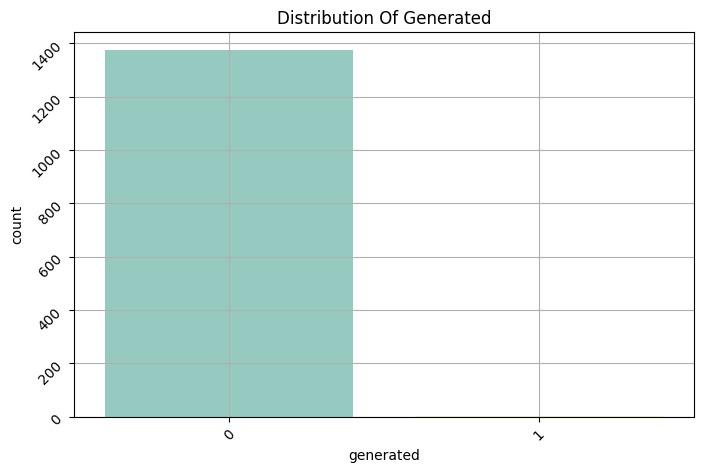

In [ ]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train,x="generated",palette='Set3')
abs_values = train['generated'].value_counts().values
# ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Generated")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
new_data=pd.read_csv("train_v2_drcat_02.csv")
new_data.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [ ]:
new_data.label.value_counts()

0    27371
1    17497
Name: label, dtype: int64

In [ ]:
train_prompts.prompt_name.value_counts()

Car-free cities                     1
Does the electoral college work?    1
Name: prompt_name, dtype: int64

In [ ]:
new_data.prompt_name.value_counts()

Distance learning                        5554
Seeking multiple opinions                5176
Car-free cities                          4717
Does the electoral college work?         4434
Facial action coding system              3084
Mandatory extracurricular activities     3077
Summer projects                          2701
Driverless cars                          2250
Exploring Venus                          2176
Cell phones at school                    2119
Grades for extracurricular activities    2116
Community service                        2092
"A Cowboy Who Rode the Waves"            1896
The Face on Mars                         1893
Phones and driving                       1583
Name: prompt_name, dtype: int64

In [ ]:
new_=new_data.iloc[:, 0:2][new_data['prompt_name'].isin(train_prompts['prompt_name'].values)]
new_

,text,label
1168,Cars have been around for awhile and they have...,0
1169,Have you ever thought what it would be like no...,0
1170,What you are about to read is going to give yo...,0
1171,cars have many flaws nd and in this day and ag...,0
1172,There are many advantages of limiting car usag...,0
...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1
44864,"Dear Senator,\n\nI am writing to you today to ...",1
44865,"Dear Senator,\n\nI am writing to you today to ...",1
44866,"Dear Senator,\n\nI am writing to you today to ...",1


In [ ]:
t=train.iloc[:,2:]
t.columns=['text','label']
train_data=pd.concat([new_,t])
train_data=train_data.reset_index().iloc[:,1:]
train_data.head()

,text,label
0,Cars have been around for awhile and they have...,0
1,Have you ever thought what it would be like no...,0
2,What you are about to read is going to give yo...,0
3,cars have many flaws nd and in this day and ag...,0
4,There are many advantages of limiting car usag...,0


In [ ]:
train_data.label.value_counts()

0    6755
1    3774
Name: label, dtype: int64

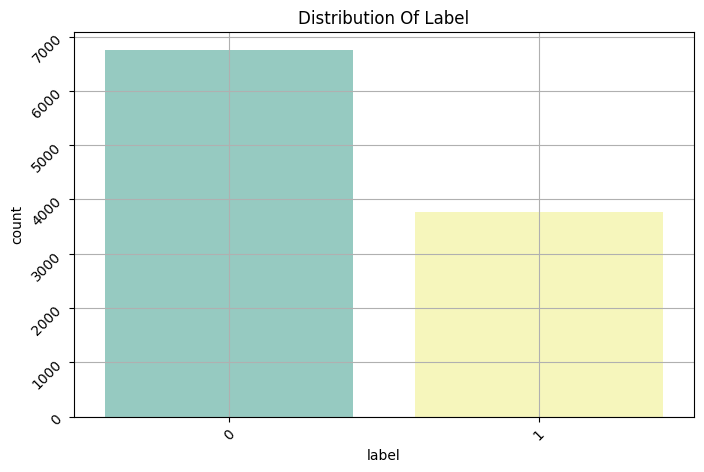

In [ ]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train_data,x="label",palette='Set3')
abs_values = train_data['label'].value_counts().values
# ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Label")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

text cleaning


In [ ]:
def Clean(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.regex_replace(text, '\.\.\.', ' ')
    text = tf.strings.join(['',text, ''], separator=' ')
    return text
def clean_text(text):
    # Remove Twitter handles starting with '@'
    text = re.sub(r'@\w+', '', text)
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [ ]:
train_data['text'][0]

'Cars have been around for awhile and they have had a major impact on society. Many people believe that there is no problem with the frequency of cars being driven. But, there are many advantages to less car use such as improving our cities and suburbs, improving safety, and decreasing pollution.\n\nMany have tried to make cities a little more dense and better for walking but nothing has seemed to work; therefore, they have moved on to suburbs. Now, people are trying to make suburbs better for getting around while walking instead of driving. By doing so, places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option. By having these suburbs, and soon hopefully cities, reduce the amount of cars used, the people living in these areas will be able to accomplish more in a healthier and safer way.\n\nSafety has been an issue in almost all areas due to a variety of reasons; one being cars. People pass by "Drive Safely" signs

In [ ]:
Clean(train_data['text'][0])

<tf.Tensor: shape=(), dtype=string, numpy=b' cars have been around for awhile and they have had a major impact on society .  many people believe that there is no problem with the frequency of cars being driven .  but ,  there are many advantages to less car use such as improving our cities and suburbs ,  improving safety ,  and decreasing pollution . many have tried to make cities a little more dense and better for walking but nothing has seemed to work therefore ,  they have moved on to suburbs .  now ,  people are trying to make suburbs better for getting around while walking instead of driving .  by doing so ,  places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option .  by having these suburbs ,  and soon hopefully cities ,  reduce the amount of cars used ,  the people living in these areas will be able to accomplish more in a healthier and safer way . safety has been an issue in almost all areas due to a vari

In [ ]:
clean_text(train_data['text'][0])

'cars have been around for awhile and they have had a major impact on society many people believe that there is no problem with the frequency of cars being driven but there are many advantages to less car use such as improving our cities and suburbs improving safety and decreasing pollution many have tried to make cities a little more dense and better for walking but nothing has seemed to work therefore they have moved on to suburbs now people are trying to make suburbs better for getting around while walking instead of driving by doing so places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option by having these suburbs and soon hopefully cities reduce the amount of cars used the people living in these areas will be able to accomplish more in a healthier and safer way safety has been an issue in almost all areas due to a variety of reasons one being cars people pass by drive safely signs or memorials on the side o

Text Vectorization


In [ ]:
max_features = 75000#max number of words that will be used in predictions-unique
embedding_dim = 64
sequence_length = 512*2#The maximum length of the sequences. It's set to 512*2, which implies sequences of up to 1024 tokens.
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=Clean ,
    max_tokens=max_features,
    ngrams = (3,5),
    output_mode="int",
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True
)
vectorize_layer.adapt(train_data['text'])
Text = vectorize_layer(train_data['text']).numpy()
Text

ModuleNotFoundError: No module named 'tensorflow_text'

In [ ]:
sm = SMOTE(random_state=44)
Text,labels= sm.fit_resample(Text,train_data['label'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Text,labels, test_size=0.2, random_state=44, shuffle =True,stratify=labels)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (10808, 1024)
X_test shape is  (2702, 1024)
y_train shape is  (10808,)
y_test shape is  (2702,)


transformers block


In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()#method initializes the layers within the Transformer block, including multi-head self-attention, feed-forward network (FFN), layer normalization, and dropout layers
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
inputs = Input(shape=(sequence_length,), dtype="int64")
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
transformer_block = TransformerBlock(embedding_dim, 2, 32)
x = transformer_block(x)
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 embedding (Embedding)       (None, 1024, 64)          4800000   
                                                                 
 bidirectional (Bidirection  (None, 1024, 64)          24832     
 al)                                                             
                                                                 
 transformer_block (Transfo  (None, 1024, 64)          37664     
 rmerBlock)                                                      
                                                                 
 conv1d (Conv1D)             (None, 340, 128)          57472     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0     

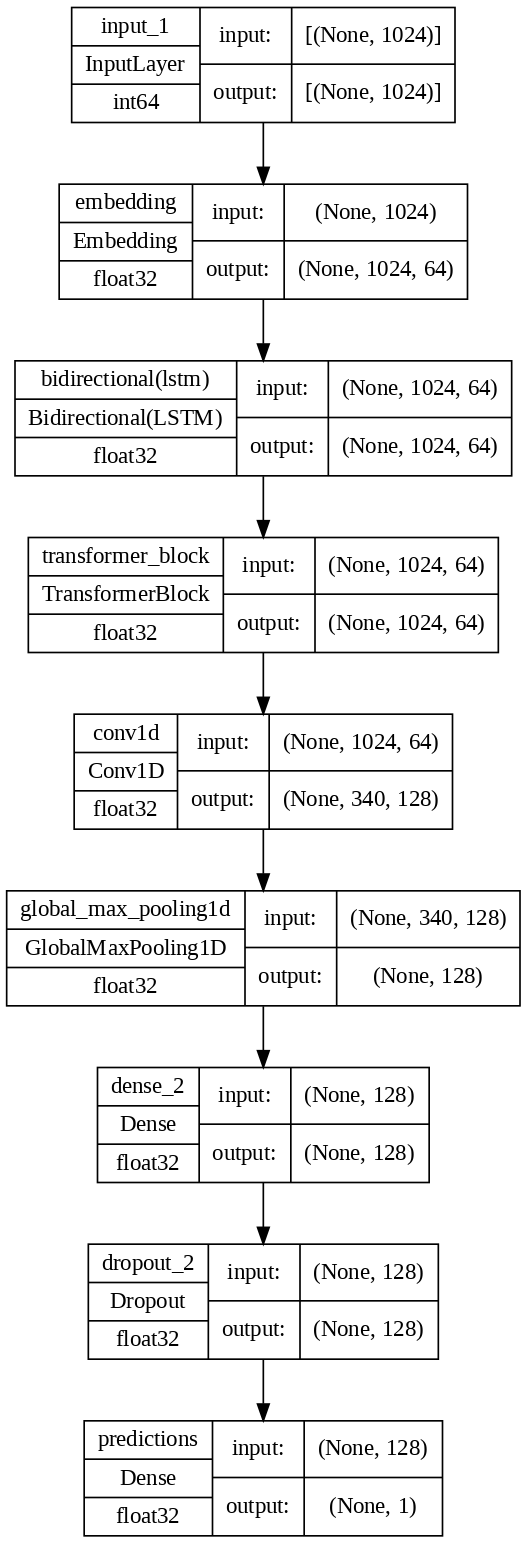

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("model_semifinal.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=5, validation_split=.1, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
304/304 [==============================] - 1438s 5s/step - loss: 0.1197 - accuracy: 0.9545 - val_loss: 0.0136 - val_accuracy: 0.9954
Epoch 2/5
304/304 [==============================] - 1382s 5s/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0162 - val_accuracy: 0.9954
Epoch 3/5
304/304 [==============================] - 1386s 5s/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0229 - val_accuracy: 0.9944
Epoch 4/5
304/304 [==============================] - 1367s 4s/step - loss: 9.5736e-05 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9926


In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.119656,0.954457,0.013558,0.995375
1,0.011726,0.996710,0.016245,0.995375
2,0.003490,0.998972,0.022946,0.994450
3,0.000096,1.000000,0.025434,0.992599


In [ ]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

85/85 [==============================] - 138s 2s/step - loss: 0.0140 - accuracy: 0.9944
Test Loss = 0.01399681344628334
Test Accuracy = 0.9944485425949097


In [ ]:
predictions = model.predict(X_test)
y_pred = np.where(predictions>=.5,1,0)
y_test_1d = np.ravel(y_test)
y_pred_1d = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test_1d, 'Prediction': y_pred_1d})
df

85/85 [==============================] - 142s 2s/step


,Actual,Prediction
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
2697,0,0
2698,1,1
2699,0,0
2700,1,1


array([[1342,    9],
       [   6, 1345]])

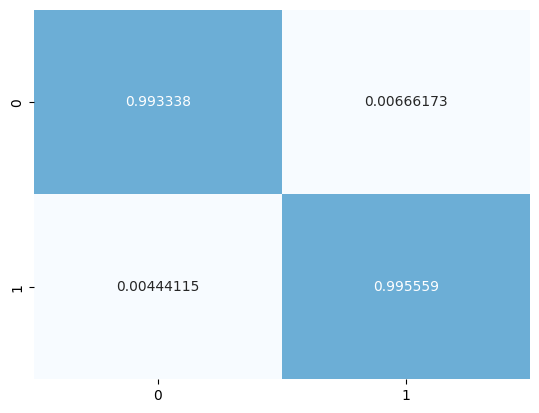

In [ ]:
CM = confusion_matrix(y_test_1d,y_pred_1d)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test_1d,y_pred_1d)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      0.99      0.99      1351
           1       0.99      1.00      0.99      1351

    accuracy                           0.99      2702
   macro avg       0.99      0.99      0.99      2702
weighted avg       0.99      0.99      0.99      2702



In [ ]:
print(X_test)

[[13963  7984  4061 ...     0     0     0]
 [31530 10384     1 ...     1     1     1]
 [  112    79    77 ...     0     0     0]
 ...
 [  638   784   247 ...     0     0     0]
 [  112    79  4022 ...     1 14882 16140]
 [    1 27606     1 ...     0     0     0]]


In [ ]:
!cp "/content/drive/My Drive/6th sem project/subtaskA_train_monolingual.jsonl" "subtaskA_train_monolingual.jsonl"

In [ ]:
print("hey")

hey


In [ ]:
human1="car free cities is a topic being talked about a lot but very hard to implement in real life.Its a concept being introduceed way too early than it can be implemented.More than 80 percent of working individuals depend on cars for travelling to and from their workplace .Not even talking about how many important services like ambulance ,police are all based on motor vehicles which cant be relaced any soon .it does offer a hell lot of advantages like less pollution,healthy lifestyle as more and more people will indulge in walking to nearby places where they didnt used to as there was an availability of their own car or pretty famous these days -cab services.we cant ignore the disadvantages in this concept-it will lead to big manufacturing companies in turn shutting down which will lead to unemployment issues and our country is not in a state where it can afford more of unemployment as the IT crisis exists beforehand."

In [ ]:
cleaned_paragraph=clean_text(human1)
# print(cleaned_paragraph)
cleaned_paragraph=Clean(human1)
print(cleaned_paragraph)

tf.Tensor(b' car free cities is a topic being talked about a lot but very hard to implement in real life . its a concept being introduceed way too early than it can be implemented . more than  percent of working individuals depend on cars for travelling to and from their workplace  . not even talking about how many important services like ambulance  , police are all based on motor vehicles which cant be relaced any soon  . it does offer a hell lot of advantages like less pollution , healthy lifestyle as more and more people will indulge in walking to nearby places where they didnt used to as there was an availability of their own car or pretty famous these days cab services . we cant ignore the disadvantages in this conceptit will lead to big manufacturing companies in turn shutting down which will lead to unemployment issues and our country is not in a state where it can afford more of unemployment as the it crisis exists beforehand . ', shape=(), dtype=string)


In [ ]:
vectorized_paragraph = vectorize_layer([cleaned_paragraph])

In [ ]:
prediction = model.predict(vectorized_paragraph)
rounded_prediction = np.round(prediction).astype(int)

1/1 [==============================] - 0s 200ms/step


In [ ]:
print("Rounded Prediction:", rounded_prediction)

Rounded Prediction: [[0]]


In [ ]:
human2="have you ever imagined what would have happened if cars- that are now  such an important part of our day to day lives would have not exsisted. probably the cities we live in would be just as we want them to be , less pollution, no long traffic queue  and no loud horn noises.  cars are one of the main cause for air pollution and so there would be less emission which eventually make the air quality index rise. not only pollution but the death cause due to car accidents are also something that we hear about every now and then, which would be saved . other mass transportation services would be preferred  and hence would have helped in achieving sustainability"

In [ ]:
cleaned_paragraph=clean_text(human2)
# print(cleaned_paragraph)
cleaned_paragraph=Clean(human2)
print(cleaned_paragraph)

tf.Tensor(b' have you ever imagined what would have happened if cars that are now  such an important part of our day to day lives would have not exsisted .  probably the cities we live in would be just as we want them to be  ,  less pollution ,  no long traffic queue  and no loud horn noises .   cars are one of the main cause for air pollution and so there would be less emission which eventually make the air quality index rise .  not only pollution but the death cause due to car accidents are also something that we hear about every now and then ,  which would be saved  .  other mass transportation services would be preferred  and hence would have helped in achieving sustainability ', shape=(), dtype=string)


In [ ]:
vectorized_paragraph = vectorize_layer([cleaned_paragraph])

In [ ]:
prediction = model.predict(vectorized_paragraph)
rounded_prediction = np.round(prediction).astype(int)

1/1 [==============================] - 0s 111ms/step


In [ ]:
print("Rounded Prediction:", rounded_prediction)

Rounded Prediction: [[1]]


In [ ]:
import pandas as pd

# Read the JSON Lines file into a DataFrame
df = pd.read_json('subtaskA_train_monolingual.jsonl', lines=True)

# Now 'df' contains the JSON data in a DataFrame format
print(df)


                                                     text  label    model  \
0       Forza Motorsport is a popular racing game that...      1  chatGPT   
1       Buying Virtual Console games for your Nintendo...      1  chatGPT   
2       Windows NT 4.0 was a popular operating system ...      1  chatGPT   
3       How to Make Perfume\n\nPerfume is a great way ...      1  chatGPT   
4       How to Convert Song Lyrics to a Song'\n\nConve...      1  chatGPT   
...                                                   ...    ...      ...   
119752  The paper is an interesting contribution, prim...      0    human   
119753  \nWe thank the reviewers for all their comment...      0    human   
119754  The authors introduce a semi-supervised method...      0    human   
119755  This paper proposes the Neural Graph Machine t...      0    human   
119756  The paper proposes a model that aims at learni...      0    human   

          source      id  
0        wikihow       0  
1        wikihow     

In [ ]:
df['text'] = df['text'].apply(Clean)

In [ ]:
# Assuming you have read the JSON Lines file into a DataFrame and cleaned the text data
texts = df['text'].tolist()  # Convert the text data to a list of strings
vectorized_text = vectorize_layer(texts)  # Apply the TextVectorization layer


In [ ]:
vectorized_text_subset = vectorized_text[:50000]

In [ ]:
predictions_subset = model.predict(vectorized_text_subset)

1563/1563 [==============================] - 2796s 2s/step


In [ ]:
binary_predictions_subset = (predictions_subset > 0.1).astype('int32')

In [ ]:
from sklearn.metrics import accuracy_score

y_true_subset = df['label'].tolist()[:50000]  # Extract ground truth labels for the subset
accuracy_subset = accuracy_score(y_true_subset, binary_predictions_subset)
print("Accuracy for the subset:", accuracy_subset)

Accuracy for the subset: 0.95056


In [ ]:
# Add a column of predictions to the DataFrame for the subset
df_subset = df.head(50000)  # Extract the first 10,000 rows of the DataFrame
df_subset['predicted_label'] = binary_predictions_subset

In [ ]:
# Display the DataFrame with predictions and ground truth labels for the subset
print(df_subset[['text', 'label', 'predicted_label']])

                                                    text  label  \
0      tf.Tensor(b' forza motorsport is a popular rac...      1   
1      tf.Tensor(b' buying virtual console games for ...      1   
2      tf.Tensor(b' windows nt  .  was a popular oper...      1   
3      tf.Tensor(b' how to make perfumeperfume is a g...      1   
4      tf.Tensor(b' how to convert song lyrics to a s...      1   
...                                                  ...    ...   
49995  tf.Tensor(b' this paper attempts to solve a ve...      1   
49996  tf.Tensor(b' the paper prides itself on being ...      1   
49997  tf.Tensor(b' this paper is a good start for de...      1   
49998  tf.Tensor(b' the paper is technically sound . ...      1   
49999  tf.Tensor(b' the authors describe a method of ...      1   

       predicted_label  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
49995               